# Grader - does all grading and calculating
- Manually convert the dat file into an excel file using excel. Only extract the serial number, name and Answers, and make sure Answers is text. **Serial number should not be text**
- Make sure all initializations in myconfig.py are correct

In [1]:
from myconfig import *
from grader_funs import *

C:\Users\souri\Dropbox\Machinegrading\Master\grader_funs.py:9: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [2]:
rawdatafilename = ''
if os.path.exists(good_name+".xlsx"):
    rawdatafilename=good_name
    datafilename=rawdatafilename+'.xlsx'
    trash_files('*fake*')

if os.path.exists(fake_name+".xlsx"):
    rawdatafilename= fake_name
    datafilename=rawdatafilename+'.xlsx'

assert rawdatafilename, "Make sure either {} or {} is ready".format(good_name,fake_name)
print("Using data from {}.xlsx".format(rawdatafilename))


# gradebook='BSGrades.csv'
assert(os.path.isfile(datafilename)),'Make sure '+datafilename+" is ready"
assert(os.path.isfile(gradebook)),'Make sure '+gradebook+' is ready'

df = pd.read_excel(datafilename, header=None, usecols=[0,1,2], names = ["Srl No", "Name", "Answers"], dtype='str')
#parse_cols makes sure that only cols 0,1 and 2 are extracted
just_answers_df=df.loc[:,"Answers"]
#checking for blanks, print only if blanks found
asterisks = False
blankers=df[df['Answers'].str.contains(" ")]
stars = df[df['Answers'].str.contains('\*')]
if not blankers.empty:
    print("The following scantrons had blanks in them. Please resolve before proceeding.")
    display(blankers)
if not stars.empty:
    print("The following scantrons were flagged as unclear. Please resolve before proceeding.")
    display(stars)
    asterisks = True
ER=check_serial_numbers(gradebook,datafilename)
if not ER.empty:
    display(ER)

df["Missed"] = ""
df["Score"]=0
df["Percentage"]=np.nan
number_of_questions_from_scantrons=len(df.loc[0,"Answers"])
available_points = (number_of_questions_from_scantrons-1)*points_per_question

Using data from All.xlsx
The following scantrons had blanks in them. Please resolve before proceeding.


,Srl No,Name,Answers
2,1009,HAN KARIN,0110241221 4040


,Registered Name,Srl No,Entered Name
1,Bolling Atiyaa,1003,NaN
12,Muezzinoglu Mine,1018,NaN
2,Carlson Brynn,1002,CARLSON BRYNN L
3,Carlson Brynn,1002,MUEZZINOGLU MINE


In [3]:
assert not asterisks, "Please resolve the answerkeys with *'s in them before proceeding'"


#determining whether the test in question is a final or a midterm. 3 points dropped for a final and 2 points dropped for a midterm
tstfiles=glob.glob("*.tst")#get all tst files
tstnames=[x[:-5] for x in tstfiles]# make list of the file names
tstname = most_frequent(tstnames)# pick the most common file name, assuming that is the actual test
 

assert os.path.exists(tstname+"0.txt") |  os.path.exists("key0.txt"), "answerkey0 not found. Make sure it is named key0.txt or something like 2019_test1v0.txt"
  
if not os.path.exists(tstname+"0.txt"):
        tstname = "key"
print("Assuming answerkey files are in the .txt files named {}".format(tstname))   

if bool([x for x in tstfiles if "final" in x.lower()]):
    point_drop = point_drop_final
    fin = True
else:
    point_drop = point_drop_midterm
    fin = False
    
if freebies:
    print("{} questions are being awarded free points! (check myconfig.py)".format(len(freebies)).upper())


if skipped_questions:
    print("{} questions are being skipped!(check myconfig.py)".format(len(skipped_questions)).upper())

quids_dfs=createQuestionIDs_and_dfs(tstname, max_words=50)
QIDs=quids_dfs["IDs"]
exempts=make_special_question_list(freebies, QIDs)
skipped = make_special_question_list(skipped_questions, QIDs)

outs = getAllKeys(tstname, points_per_question, skipped)
keylist=outs["keylist"]
pointlist=outs["pointlist"]
numberOfQuestions=outs["numberOfQuestions"]
assert number_of_questions_from_scantrons == numberOfQuestions, "The number of questions on the test ({}) does not match the number of questions on the scantron ({})".format(numberOfQuestions,number_of_questions_from_scantrons)
sum_pointlists =[sum(x) for x in pointlist]
the_common_sum = set(sum_pointlists)
assert (len(the_common_sum)==1), "Each version should have the same total number of points"
totalpoints = list(the_common_sum)[0]
new_totalpoints=totalpoints-point_drop


if fin:
    print("{}x{}={} points available, but grading out of {}, dropping {} points for a final.".format(number_of_questions_from_scantrons-1,points_per_question, totalpoints, new_totalpoints, point_drop))
else:
    print("{}x{}={} points available, but grading out of {}, dropping {} points for a midterm.".format(number_of_questions_from_scantrons-1,points_per_question, totalpoints, new_totalpoints, point_drop))







numberOfVersions=len(keylist)
numberOfStudents=df.shape[0]

koschen_paper=quids_dfs['dfs']
v0_question_list = list(koschen_paper[0].loc[:,"Question"]) #List of questions in version 0
assert(keylist and pointlist and QIDs and koschen_paper and numberOfQuestions!=0),"Either keylist or pointlist or QIDs or koschen_paper or  numberOfQuestions is null"


analysis_df  = pd.DataFrame(index=range(numberOfStudents),columns = list(QIDs[0])+["score"])# stores whether answer was correct, questions are the columns, last column is the score


Assuming answerkey files are in the .txt files named test1_v
1 QUESTIONS ARE BEING AWARDED FREE POINTS! (CHECK MYCONFIG.PY)
Generating QIDs. This might take a while..
Done. That took: 0.8904180526733398 sec.
18x3=54 points available, but grading out of 51, dropping 3 points for a midterm.


In [4]:
##Everything initialized. Running the code now
   

incorrect_length =  df[(df['Answers'].map(len)<numberOfQuestions-1) | (df['Answers'].map(len)>numberOfQuestions)]
if not incorrect_length.empty:
    incorrect_length=incorrect_length[['Srl No', 'Name','Answers']]
    print("The following students had too many or too few answers")
    display(incorrect_length)
assert incorrect_length.empty, "Check that all answer strings have correct length" 

last_entry_missing=df[df['Answers'].map(len)==numberOfQuestions-1]
if not last_entry_missing.empty:
    last_entry_missing=last_entry_missing[['Srl No', 'Name','Answers']]
    print("The following students had no entry for the version question")
    display(last_entry_missing)
last_entry_space = df[(df['Answers'].str[-1] == ' ') & (df['Answers'].map(len) == numberOfQuestions)]
if not last_entry_space.empty:
    last_entry_space=last_entry_space[['Srl No', 'Name','Answers']]
    print("The following students had a blank entered for version question")
    display(last_entry_space)

print("Starting calculations...")
starttime = time()

df=process_grades(df,outs, QIDs ,analysis_df, new_totalpoints, numberOfVersions, analysis=True,exempt_questions=exempts,skipped_questions = skipped)
number_correct_by_version, students_by_version = analyse_items(df, koschen_paper,keylist)
item_analysis_df = make_item_analysis(analysis_df, v0_question_list) 
endtime = time()
print("Done. That took: "+str(endtime-starttime)+ " sec for "+str(numberOfStudents)+" students")
#check for duplicated serial numbers
dupes=df[df['Srl No'].duplicated(keep=False)]
if not dupes.empty:
    print('Warning: Duplicates in serial numbers found!')
    display(dupes)    
max_score=analysis_df.at[analysis_df['score'].idxmax(),'score']

Starting calculations...
Analysing data for version: A
Analysing data for version: B
Analysing data for version: C
Analysing data for version: D
Analysing data for version: E
Done. That took: 0.15623736381530762 sec for 139 students


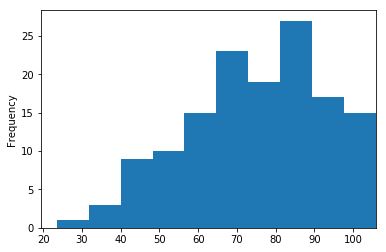

In [5]:
write_to_csv(df.sort_values('Score', ascending=False),rawdatafilename)
if (os.path.isfile('mystyle.css')):
    write_to_webpage(rawdatafilename, totalpoints, new_totalpoints,  df, item_analysis_df, point_drop, number_correct_by_version, students_by_version, list_of_free_qs=exempts, list_of_skipped_qs=skipped)
else:
    print("Copy the css file over first")

In [ ]:
#Grades and displays the N'th entry in the list using a keylist
N=random.randint(1,df.shape[0]-1)
#for N in range(df.shape[0]-1):
#N=9
exempts=make_special_question_list(freebies, QIDs)
check1=gradeWithKeylist(df.iat[N,2], outs, QIDs, analysis_df, analysis=False, exempt_questions=exempts, skipped_questions=skipped)
print("Row "+ str(N)+": "+df.iat[N,1]+", "+str(df.iat[N,0])+". Missed "+str(check1['missed'])+ ". Scored "+str(check1['score'])+"/"+str(new_totalpoints))
print('That is: '+str(100*check1['score']/new_totalpoints)+'% with '+str(point_drop)+' points dropped')

In [8]:
#Searches the results by name. Enter a name or part of a name in string_to_search below
string_to_search = "wheat"
string_to_search = string_to_search.upper()
df[df['Name'].str.contains(string_to_search)] # code to search by name

,Srl No,Name,Answers,Missed,Score,Percentage
126,1062,WHEAT EMMA,1310401012334330114,"vE: 5, 11, 13, 18",42,82.352941


# DEVELOPMENT AREA
## All code below is in development


In [ ]:
msd=check1['missed']

In [ ]:
msd.upper()

In [ ]:
def remove_whitespace(string): 
    return string.replace(" ", "") 

In [ ]:
msd = remove_whitespace(msd)

In [ ]:
msd

In [ ]:
og1.head()

In [ ]:
from myconfig import *

In [ ]:
good_name

In [ ]:
freebies

In [ ]:
fake_name

In [ ]:
sum_pointlists =[sum(x) for x in pointlist]
the_common_sum = set(sum_pointlists)
assert((len(the_common_sum)==1))
list(the_common_sum)[0]

In [ ]:
assert((len(the_common_sum)==1))

In [ ]:
list(the_common_sum)[0]

In [ ]:
sum_of_points

In [ ]:
tstname

In [ ]:
tstfiles=glob.glob("*.tst")

In [ ]:
tstfiles

In [ ]:
tstfiles[0][:-5]

In [ ]:
tstnames=[x[:-5] for x in tstfiles]

In [ ]:
unique_names = list(set(tstnames))

In [ ]:
unique_names[1]

In [ ]:
def most_frequent(name_list): 
    return max(set(name_list), key = name_list.count)

In [ ]:
most_frequent(tstnames)